Task 1: 
Number of SIFT features (default settings):  6233
Number of SIFT features (custom settings (10%)):  623


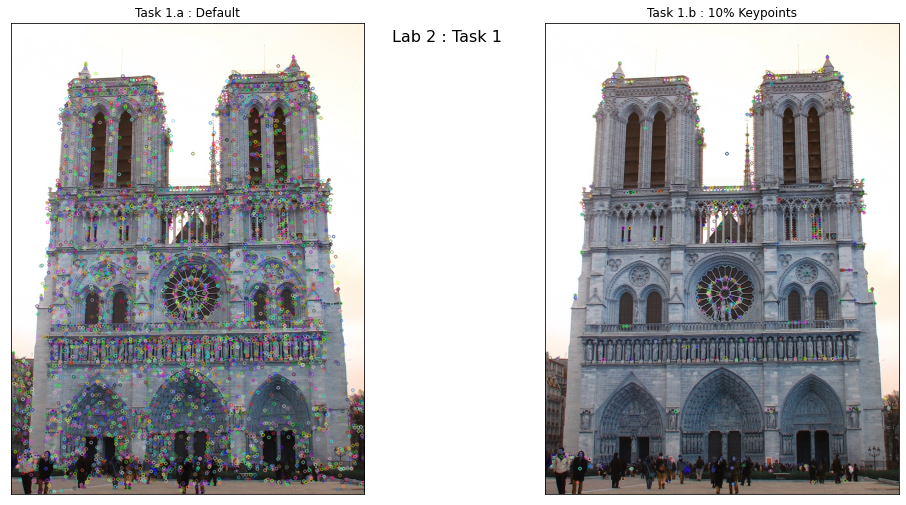


Task 2:
Number of SIFT features:  623


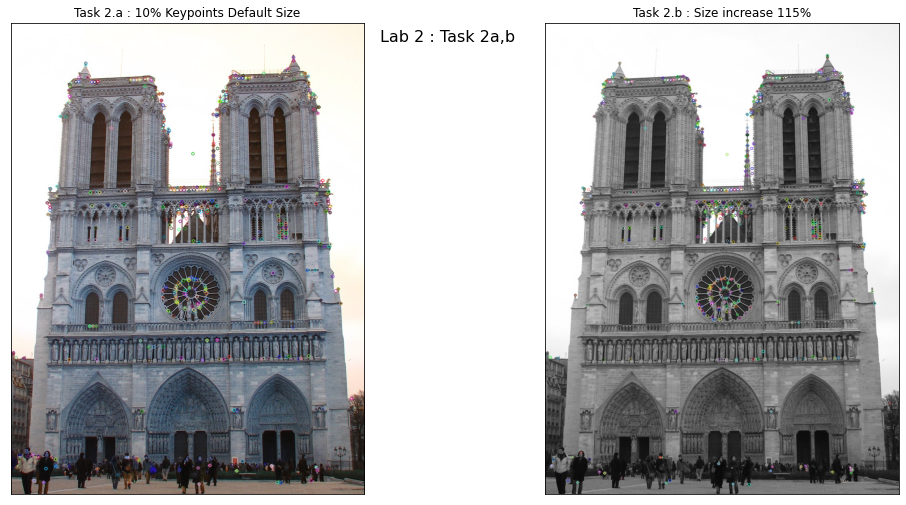

Task 2.c:
The keypoints are roughly the same even when the image is rescaled. The lines still connect to the same keypoints between two images. Which proves that SIFT is scale-invariant


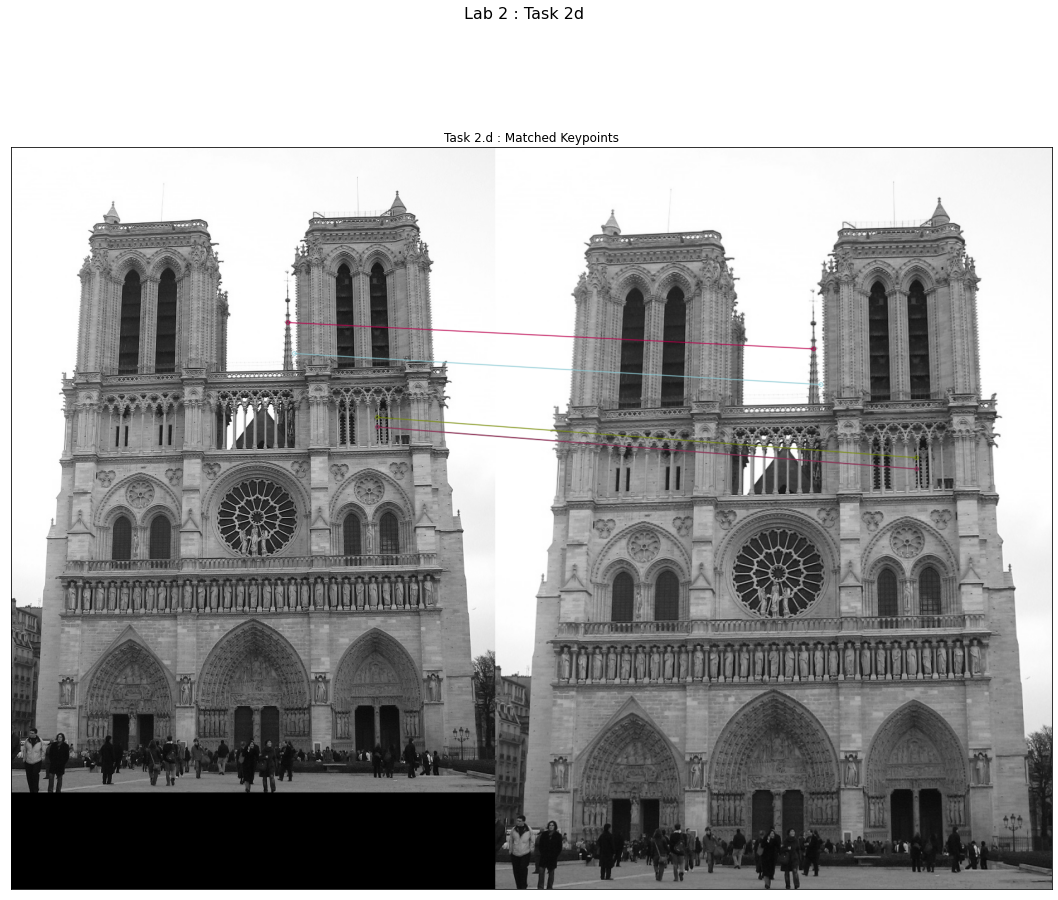


Task 3:
Number of SIFT features:  623


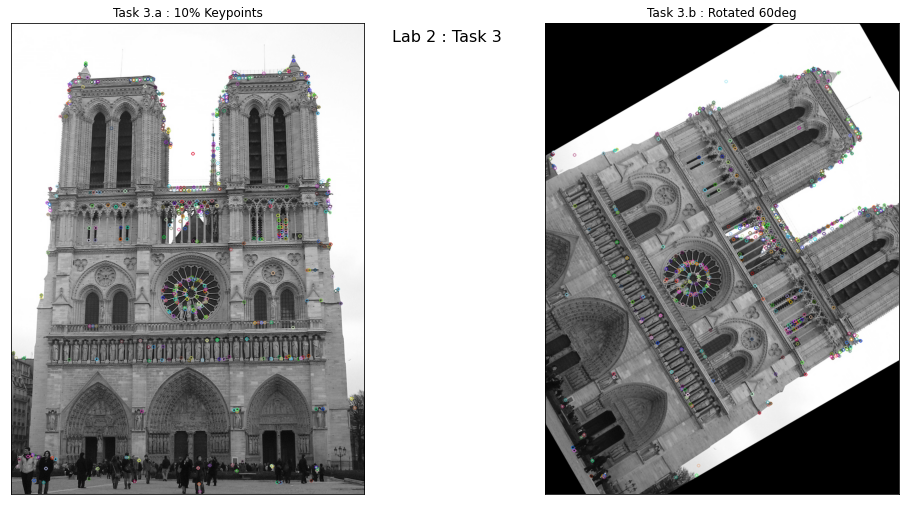

Task 3.c:
Although the orientation of the pattern of pixels in the rotated image is different, the SIFT algorithm is able to see through that. SIFT found the same keypoints in each of the two very different views.


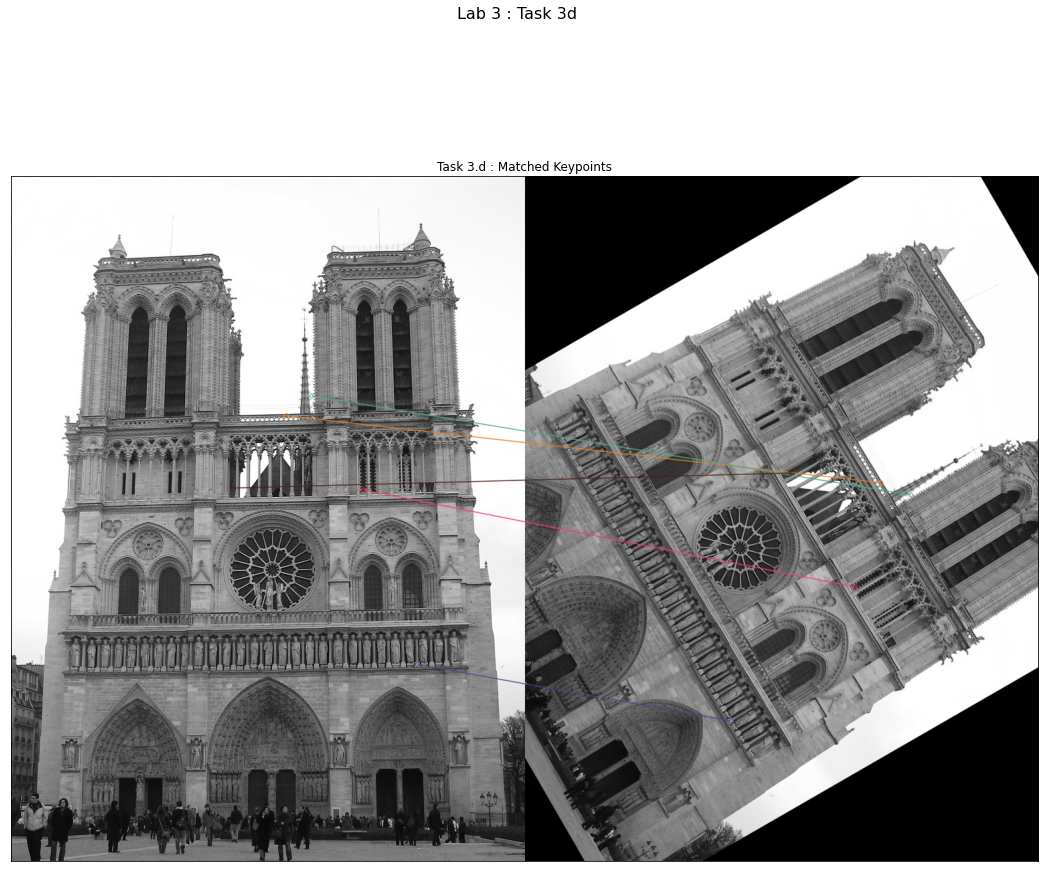

The SIFT feature descriptor is invariant to uniform scaling, orientation, illumination changes, and partially invariant to affine distortion.


In [3]:
import cv2
import matplotlib.pyplot as plt

class SiftDetector():
    def __init__(self, norm="L2", params=None):
        self.detector=self.get_detector(params)
        self.norm=norm

    def get_detector(self, params):
        if params is None:
            params={}
            params["n_features"]=0
            params["n_octave_layers"]=3
            params["contrast_threshold"]=0.03
            params["edge_threshold"]=10
            params["sigma"]=1.6

        detector = cv2.xfeatures2d.SIFT_create(
                nfeatures=params["n_features"],
                nOctaveLayers=params["n_octave_layers"],
                contrastThreshold=params["contrast_threshold"],
                edgeThreshold=params["edge_threshold"],
                sigma=params["sigma"])

        return detector

#----------------------------------------------------------------------------------------------#

#Task 1 Kovid:
# Initialize SIFT detector, detect keypoints, store and show SIFT keypoints of original image in a Numpy array
# Define parameters for SIFT initializations such that we find only 10% of keypoints

def task1(image):    
    #DEFAULT Params
    # 1. Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # 2. Initialize SIFT detector with default params
    sift = SiftDetector()
    # 3. Detect SIFT features
    kp = sift.detector.detect(gray, None)
    # 4. Visualize detected features
    kp_gray_default = cv2.drawKeypoints(image, kp, gray)
    # Print number of SIFT features detected
    print("Number of SIFT features (default settings): ", len(kp))
#     cv2.imwrite('Task_1_a_Deafult_Keypoints.jpg', kp_gray_default)
#     cv2.imshow("Keypoints image", kp_gray_default)
#     cv2.waitKey(900)
#     cv2.destroyAllWindows()

    #For 10% keypoints
    # Parameters for SIFT initializations such that we find only 10% of keypoints
    params = {
        'n_features': 623,    #update this to 100, to view only 100 keypoints
        'n_octave_layers': 3,
        'contrast_threshold': 0.03,  # updated threshold.This value will vary for different images to view 25% of keypoints.
        'edge_threshold': 10,
        'sigma': 1.6
    }
    # 1. Initialize SIFT detector
    sift = SiftDetector(params=params)
    # 2. Detect SIFT features
    kp = sift.detector.detect(gray, None)
    # 3. Visualize detected features
    kp_gray_10 = cv2.drawKeypoints(image, kp, gray)
    # Print number of SIFT features detected
    print("Number of SIFT features (custom settings (10%)): ", len(kp))
#     cv2.imwrite('Task_1_b_10%_Keypoints.jpg', kp_gray_10)
#     cv2.imshow("Keypoints image 10%", kp_gray_10)
#     cv2.waitKey(900)
#     cv2.destroyAllWindows()

    #plotting images
    fig, axs = plt.subplots(1,2,figsize=(15,15)) #increase window size
    #title for plot
    fig.tight_layout(rect=[0, 0, 1, 1])
    fig.suptitle('Lab 2 : Task 1', fontsize=16)
    plt.subplot(2,2,1),plt.imshow(kp_gray_default, cmap = 'gray', vmin=0, vmax=255)
    plt.title('Task 1.a : Default'), plt.xticks([]), plt.yticks([])
    plt.subplot(2,2,2),plt.imshow(kp_gray_10,cmap = 'gray', vmin=0, vmax=255)
    plt.title('Task 1.b : 10% Keypoints'), plt.xticks([]), plt.yticks([])
    plt.show()
    
#----------------------------------------------------------------------------------------------#

#Task 2 Kovid:
# Upscale the image, compute SIFT features for rescaled image
# Apply BFMatcher with defined params and ratio test to obtain good matches, and then select and draw best 5 matches

def task2(image):
    grayImageOrig = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #For 10% keypoints
    # Parameters for SIFT initializations such that we find only 10% of keypoints
    params = {
        'n_features': 623,    #update this to 100, to view only 100 keypoints
        'n_octave_layers': 3,
        'contrast_threshold': 0.03,  # updated threshold.This value will vary for different images to view 25% of keypoints.
        'edge_threshold': 10,
        'sigma': 1.6
    }
    sift = SiftDetector(params=params)
    
    # Store SIFT keypoints of original image in a Numpy array
    kp,des1 = sift.detector.detectAndCompute(grayImageOrig, None)
    print("Number of SIFT features: ", len(kp))
    kp_gray = cv2.drawKeypoints(image, kp, grayImageOrig)
    
#     cv2.imwrite("Task_2_Original_Keypoints.jpg", kp_gray)
#     cv2.imshow("Original keypoints", kp_gray)    
#     cv2.waitKey(900)
#     cv2.destroyAllWindows()
    
    #Upscale the image
    scale_percent = 115  # percent of original size
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)
    # resize image
    resizedImage = cv2.resize(grayImageOrig, dim, interpolation=cv2.INTER_AREA)

    # Compute SIFT features for rescaled image
    kp_resize,des2 = sift.detector.detectAndCompute(resizedImage, None)
    kp_gray_resize = cv2.drawKeypoints(resizedImage, kp_resize, resizedImage)
#     cv2.imwrite("Task_2_a_Resize_Keypoints.jpg", kp_gray_resize)
#     cv2.imshow("Upscaled keypoints", kp_gray_resize)
#     cv2.waitKey(900)
#     cv2.destroyAllWindows()
    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    # Apply ratio test
    """This test rejects poor matches by computing the ratio between the best and second-best match. 
    If the ratio is below some threshold, the match is discarded as being low-quality."""
    good = []
    matches_top_5 = []

    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            matches_top_5.append(m.distance)
            
    matches_top_5.sort(reverse=False)

    for m, n in matches:
        if m.distance in matches_top_5[:5] :
            good.append([m])
    
    # Draw matches
    result = cv2.drawMatchesKnn(
        grayImageOrig, kp,
        resizedImage, kp_resize,
        good, None, flags=2)
    
#     cv2.imwrite("Task_2_d_Matched_Keypoints.jpg", result)
#     cv2.imshow("Matched points", result)
#     cv2.waitKey(900)
#     cv2.destroyAllWindows()
    
    #plotting images
    fig, axs = plt.subplots(1,2,figsize=(15,15)) #increase window size
    #title for plot
    fig.tight_layout(rect=[0, 0, 1, 1])
    fig.suptitle('Lab 2 : Task 2a,b', fontsize=16)
    plt.subplot(2,2,1),plt.imshow(kp_gray,cmap = 'gray', vmin=0, vmax=255)
    plt.title('Task 2.a : 10% Keypoints Default Size'), plt.xticks([]), plt.yticks([])
    plt.subplot(2,2,2),plt.imshow(kp_gray_resize,cmap = 'gray', vmin=0, vmax=255)
    plt.title('Task 2.b : Size increase 115%'), plt.xticks([]), plt.yticks([])
    plt.show()
    
    print('\033[1mTask 2.c:\033[0m')
    print('The keypoints are roughly the same even when the image is rescaled. The lines still connect to the same keypoints between two images. Which proves that SIFT is scale-invariant')
   
    #plotting images
    fig, axs = plt.subplots(1,1,figsize=(15,15)) #increase window size
    #title for plot
    fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    fig.suptitle('Lab 2 : Task 2d', fontsize=16)
    plt.subplot(1,1,1),plt.imshow(result,cmap = 'gray', vmin=0, vmax=255)
    plt.title('Task 2.d : Matched Keypoints'), plt.xticks([]), plt.yticks([])
    plt.show()
    
#----------------------------------------------------------------------------------------------#

# Task3 Hint: (with sample code for the rotation)
# Rotate the image and compute SIFT features for rotated image
# Apply BFMatcher with defined params and ratio test to obtain good matches, and then select and draw best 5 matches
import math
import numpy as np

# Returns a rotated copy of the original image
def rotate(image, x, y, angle):
    rot_matrix = cv2.getRotationMatrix2D((x, y), angle, 1.0)
    h, w = image.shape[:2]

    return cv2.warpAffine(image, rot_matrix, (w, h))

# return: (x, y) coordinates of point at center of image
def get_img_center(image):
    height, width = image.shape[:2]
    center = height // 2, width // 2
    return center

#Task 3 Kovid:
def task3(image):
    grayImageOrig = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #For 10% keypoints
    # Parameters for SIFT initializations such that we find only 10% of keypoints
    params = {
        'n_features': 623,    #update this to 100, to view only 100 keypoints
        'n_octave_layers': 3,
        'contrast_threshold': 0.03,  # updated threshold.This value will vary for different images to view 25% of keypoints.
        'edge_threshold': 10,
        'sigma': 1.6
    }
    sift = SiftDetector(params=params)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Initialize SIFT detector
    sift = SiftDetector(params=params)
    # Store SIFT keypoints of original image in a Numpy array
    kp1, des1 = sift.detector.detectAndCompute(gray, None)
    OrigKeypoints = cv2.drawKeypoints(gray, kp1, None)
    print("Number of SIFT features: ", len(kp1))
#     cv2.imwrite("Task_3_Original_Keypoints.jpg", OrigKeypoints)
#     cv2.imshow("Original keypoints", OrigKeypoints)
#     cv2.waitKey(900)
#     cv2.destroyAllWindows()

    # center of image points. 'img_center' is in (Y, X) order.
    img_center = get_img_center(gray)
    x_coord = img_center[1]
    y_coord = img_center[0]

    # Degrees with which to rotate image
    angle = -60

    # Rotate image
    rotatedImage = rotate(gray, x_coord, y_coord, angle)
#     cv2.imwrite("Task_3_a_Rotated.jpg", rotatedImage)
    
    # Compute SIFT features for rotated image
    kp2, des2 = sift.detector.detectAndCompute(rotatedImage, None)
    kp_gray = cv2.drawKeypoints(rotatedImage, kp2, None)

    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

#     cv2.imwrite("Task_3_b_Rotated_Keypoints.jpg", kp_gray)
#     cv2.imshow("Rotated keypoints", kp_gray)
#     cv2.waitKey(900)
#     cv2.destroyAllWindows()
    
    # Apply ratio test
    """This test rejects poor matches by computing the ratio between the best and second-best match. 
    If the ratio is below some threshold, the match is discarded as being low-quality."""
    good = []
    matches_top_5 = []

    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            matches_top_5.append(m.distance)
            
    matches_top_5.sort(reverse=False)
    
    for m, n in matches:
        if m.distance in matches_top_5[:5] :
            good.append([m])
                
    # cv2.drawMatchesKnn
    result = cv2.drawMatchesKnn(
        grayImageOrig, kp1,
        rotatedImage, kp2,
        good, None, flags=2)
    
#     cv2.imwrite("Task_3_d_Matched_Keypoints.jpg", result)    
#     cv2.imshow("Matched points", result)
#     cv2.waitKey(900)
#     cv2.destroyAllWindows()

    #plotting images
    fig, axs = plt.subplots(1,2,figsize=(15,15)) #increase window size
    #title for plot
    fig.tight_layout(rect=[0, 0, 1, 1])
    fig.suptitle('Lab 2 : Task 3', fontsize=16)
    plt.subplot(2,2,1),plt.imshow(OrigKeypoints,cmap = 'gray', vmin=0, vmax=255)
    plt.title('Task 3.a : 10% Keypoints'), plt.xticks([]), plt.yticks([])
    plt.subplot(2,2,2),plt.imshow(kp_gray,cmap = 'gray', vmin=0, vmax=255)
    plt.title('Task 3.b : Rotated 60deg'), plt.xticks([]), plt.yticks([])
    plt.show()
    
    print('\033[1mTask 3.c:\033[0m')
    print('Although the orientation of the pattern of pixels in the rotated image is different, the SIFT algorithm is able to see through that. SIFT found the same keypoints in each of the two very different views.')
    #plotting images
    fig, axs = plt.subplots(1,1,figsize=(15,15)) #increase window size
    #title for plot
    fig.tight_layout()
    fig.suptitle('Lab 3 : Task 3d', fontsize=16)
    plt.subplot(1,1,1),plt.imshow(result,cmap = 'gray', vmin=0, vmax=255)
    plt.title('Task 3.d : Matched Keypoints'), plt.xticks([]), plt.yticks([])
    plt.show()

#Main section - Kovid
image = cv2.imread("COMP9517_20T2_Lab2_Image.jpg")
print('\033[1mTask 1: \033[0m')
task1(image)
print('\033[1m\nTask 2:\033[0m')
task2(image)
print('\033[1m\nTask 3:\033[0m')
task3(image)
print('The SIFT feature descriptor is invariant to uniform scaling, orientation, illumination changes, and partially invariant to affine distortion.')